In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase.io as aio
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy
import numba
import pandas as pd
from scipy.spatial import cKDTree
from toolz.curried import pipe, curry
import atom_stat as astat

In [3]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
def draw(im):
    im1 = np.squeeze(im)
    plt.imshow(im1)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
@numba.njit(parallel=True)
def make_box(box, indexes, N, shape):
    sx, sy, sz = shape
    for i in range(N):
        cx, cy, cz = indexes[i]
        if (cx < sx) and (cx >= 0):
            if (cy < sy) and (cy >= 0):
                if (cz < sz) and (cz >= 0):
                    box[cx, cy, cz] += 1

## Estimate Distrubance in 3D

For the perfect structure

In [8]:
r_stat = 8 # radius of the statistics
len_pixel = 10 # voxel size
shape = np.asarray([int(r_stat * 2 * len_pixel + 1)] * 3) # shape of the statistics box

In [9]:
fname = fname = "data/dump.clean"
df = pd.read_table(fname, 
                   delimiter=" ",
                   skiprows=9,
                   header=None)
coords = np.asarray(df.iloc[:,2:5])

tree = cKDTree(coords)

In [10]:
# Load coordinates of disturbed atom here
# and save them in the coords0 file
# They can be computed using ovito - Common Neighbour Analysis and saved in an xyz file 
# The xyz file if available can be read with ase usin the following code snippet:

# # # atom = aio.read("coords/data_%d_new.xyz" % run)
# # # coords0 = atom.get_positions()

# Right now I am randomly choosing a 100 atoms for which I will compute the Two Point Statistics

ind = np.random.randint(10000, coords.shape[0], 100)
coords0 = coords[ind]

### Compute the vector counts and save them in a matrix called box

In [12]:
%%time
stat_coords = []
count = 0
for i, coord in enumerate(coords0[:]):
    indxs = tree.query_ball_point(coord, 1.8 * r_stat)
    stat_coords.append(coords[indxs] - coord)  
stat_coords = np.concatenate(stat_coords, axis=0) + r_stat
indexes = (np.round(stat_coords * len_pixel)).astype(int)
box = np.zeros(shape)
N = indexes.shape[0]
make_box(box, indexes, N, shape)
box = box / len(coords0)

CPU times: user 488 ms, sys: 26.7 ms, total: 515 ms
Wall time: 333 ms


### Visualize the vector counts

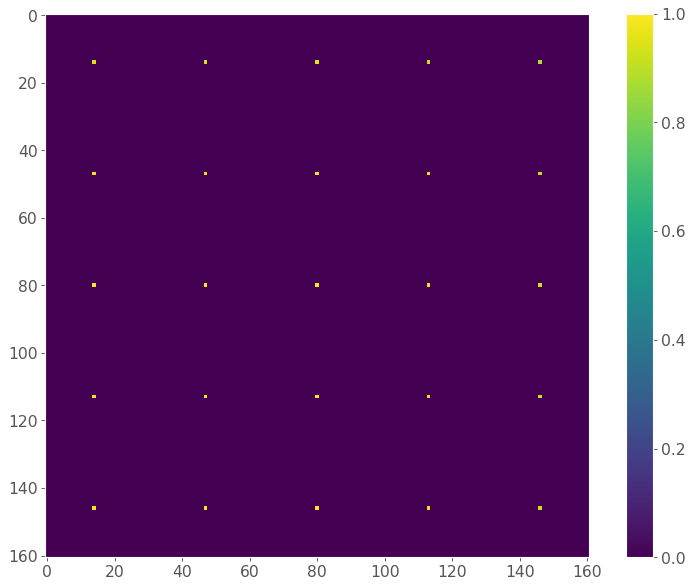

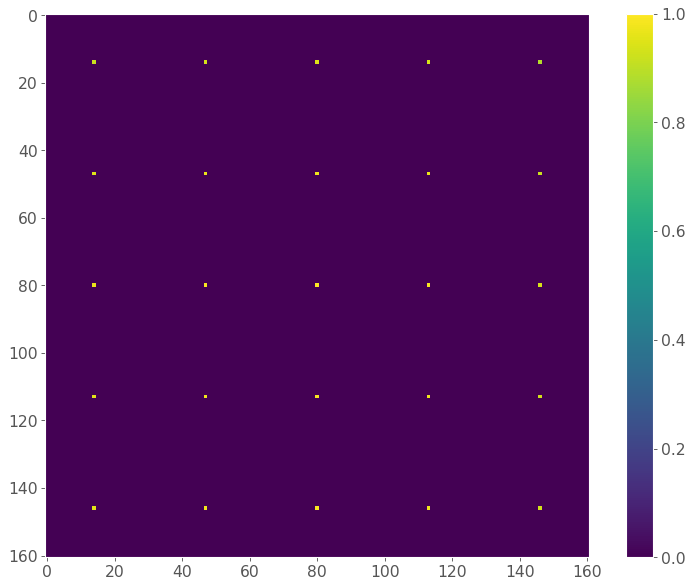

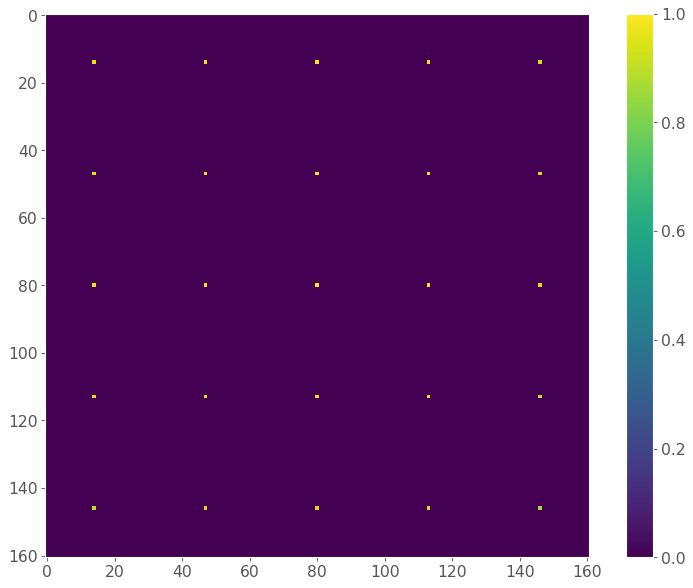

In [13]:
idx = int(r_stat * len_pixel)
draw(box[:,:, idx])
draw(box[:, idx, :])
draw(box[idx,:,:])

In [15]:
r_s = 1.0
new_shape = shape + int(2 * r_s * len_pixel)

### Compute a smoothening filter for two point statistics

In [16]:
s0 = astat.padder(astat.sphere(r_s * len_pixel), new_shape)
fs = astat.imfilter(s0, s0) / np.count_nonzero(s0)

### Visualize the smoothening filter

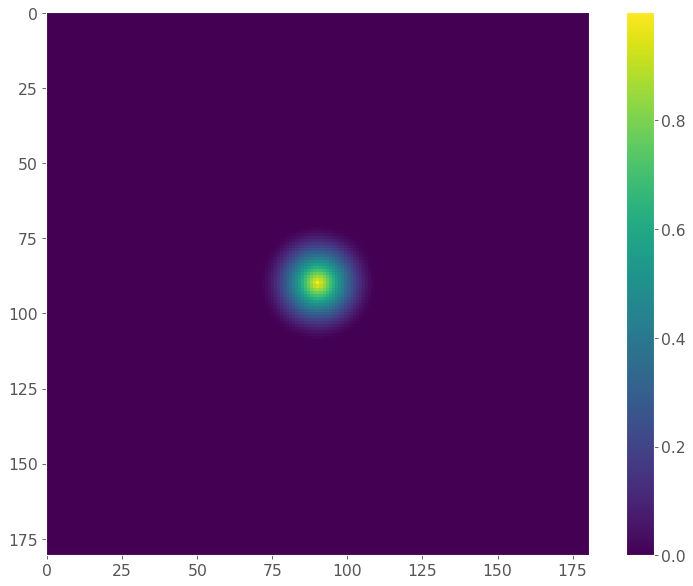

In [17]:
idx = int((r_stat + r_s) * len_pixel)
draw((fs[:,:, idx]))

## Apply the smoothening filter to the box

In [19]:
%%time
box1 = astat.padder(box, new_shape)
box1 = astat.imfilter(box1, fs)

CPU times: user 1.62 s, sys: 320 ms, total: 1.94 s
Wall time: 973 ms


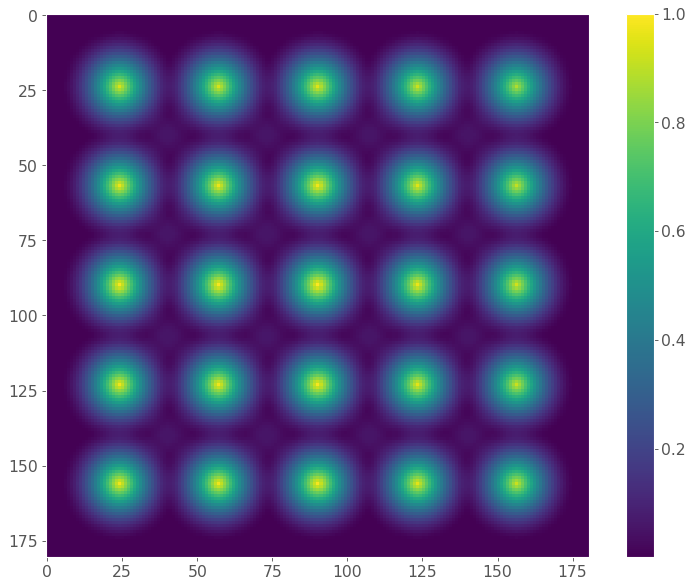

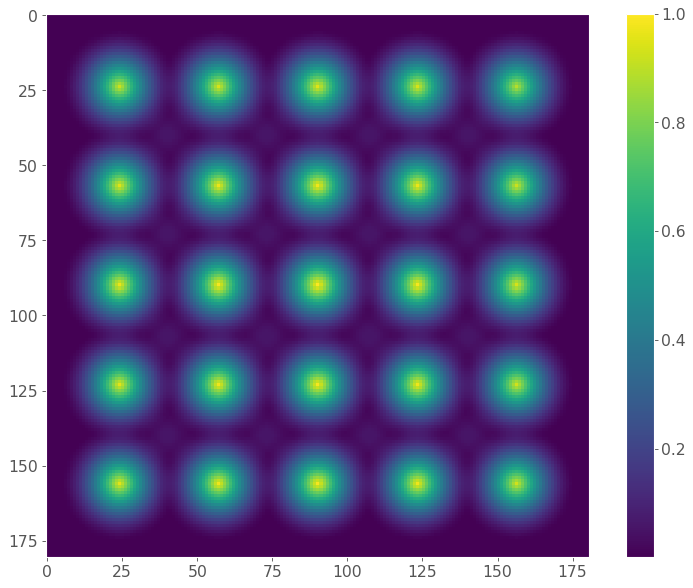

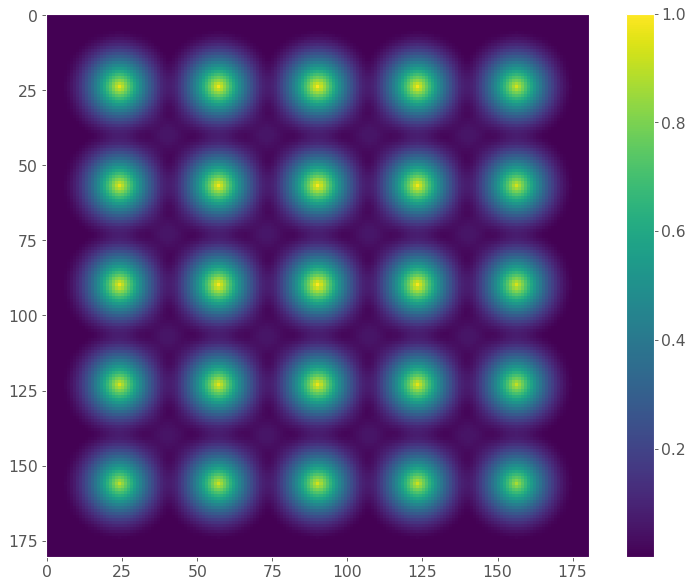

In [20]:
idx = int((r_stat + r_s) * len_pixel)
draw(box1[:,:, idx])
draw(box1[:, idx, :])
draw(box1[idx,:,:])